# **STEP 1: PROJECT DESCRIPTION & DATASET**

This project aims to identify the most effective supervised learning models for predicting future stock prices, using historical stock market data. We focus on the Standard & Poor's 500 (S&P 500) index, which provides a representative snapshot of the US market across multiple sectors including technology, healthcare, energy, and finance. Our goal is to determine which supervised learning model best predicts the stock close prices of 10 randomly selected companies from this index, based on training data from 40 other randomly selected S&P 500 companies.

We downloaded the historical stock data using Yahoo Finance’s API (yfinance) for a five-year period from November 1, 2019, to October 31, 2024. The dataset includes each company’s open, high, low, close, and adjusted close prices, as well as trading volume. To enhance model robustness, we will engineer additional technical indicators from this data, potentially improving predictive accuracy.

By evaluating a range of supervised learning algorithms with hyperparameter tuning, we will compare each model’s effectiveness on the same dataset. While stock prices are influenced by numerous external and internal factors beyond the scope of this analysis, this project provides an initial exploration of how effectively supervised learning can forecast stock price trends.

In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Set random seed for replicability
random.seed(42)

# Scrape the S&P 500 list from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)

sp500_df = sp500_table[0]

#Extract the 'Symbol' column which contains the ticker symbols
tickers = sp500_df['Symbol'].tolist()

# Randomly sample 40 tickers from the list for training companies
# Randomly sample 10 tickers from the remaining list for testing companies
train_companies = random.sample(tickers, 40)
test_companies = random.sample([company for company in tickers if company not in train_companies], 10)

# Display the sampled tickers
print(f"Train companies: {train_companies}")
print(f"Test companies: {test_companies}")

Train companies: ['MNST', 'BAC', 'AKAM', 'PPL', 'DAY', 'CPRT', 'CMS', 'BMY', 'POOL', 'AVB', 'NCLH', 'TSN', 'KLAC', 'ANET', 'MAR', 'GM', 'ALLE', 'ALGN', 'T', 'CFG', 'CAG', 'IVZ', 'MKC', 'ALB', 'LDOS', 'CHTR', 'PAYX', 'MSCI', 'OTIS', 'GD', 'CLX', 'HSY', 'MKTX', 'DE', 'NOW', 'TXN', 'ABBV', 'PHM', 'STX', 'CZR']
Test companies: ['RL', 'HWM', 'FDX', 'ETN', 'CAT', 'CPAY', 'STE', 'FAST', 'BBY', 'BKR']


In [ ]:
# Specify date range
start_date = "2020-11-01"
end_date = "2024-10-31"

# Function to download data and filter out invalid entries
def safe_download(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:  # Check if the data is empty (no data for the given date range)
            print(f"No data for {ticker} within the specified date range.")
            return None
        return data
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")
        return None

# Download data for training and testing companies, applying the safe_download function
train_data = {company: safe_download(company, start_date, end_date) for company in train_companies}
test_data = {company: safe_download(company, start_date, end_date) for company in test_companies}

# Remove companies without data
train_data = {company: data for company, data in train_data.items() if data is not None}
test_data = {company: data for company, data in test_data.items() if data is not None}

# Update the train and test company lists based on successful data downloads
train_companies = [company for company, data in train_data.items() if data is not None]
test_companies = [company for company, data in test_data.items() if data is not None]

# Display the filtered lists of companies
print(f"Filtered Train companies: {train_companies}")
print(f"Filtered Test companies: {test_companies}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Filtered Train companies: ['MNST', 'BAC', 'AKAM', 'PPL', 'DAY', 'CPRT', 'CMS', 'BMY', 'POOL', 'AVB', 'NCLH', 'TSN', 'KLAC', 'ANET', 'MAR', 'GM', 'ALLE', 'ALGN', 'T', 'CFG', 'CAG', 'IVZ', 'MKC', 'ALB', 'LDOS', 'CHTR', 'PAYX', 'MSCI', 'OTIS', 'GD', 'CLX', 'HSY', 'MKTX', 'DE', 'NOW', 'TXN', 'ABBV', 'PHM', 'STX', 'CZR']
Filtered Test companies: ['RL', 'HWM', 'FDX', 'ETN', 'CAT', 'CPAY', 'STE', 'FAST', 'BBY', 'BKR']


# **STEP 2: EXPLORATORY DATA ANALYSIS (EDA)**
To make the company stock data useful for analysis and modeling, a number of tasks were undertaken to ensure it was organized, complete, and well-structured. After selecting 50 companies and dividing them into training and testing sets, we ensured the dataset covered the entire 5-year period to maintain relevance across comparisons. Key steps in our data exploration and cleaning process included:
<br><br>
1. Converting the data to a structured DataFrame for easier analysis and calculation.
2. Filling NaN values using both forward and backfilling methods to handle missing data.
3. Standardizing data using StandardScaler to facilitate comparability between companies.
4. Adding technical indicators—50-day and 200-day Simple Moving Averages (SMA) and the Relative Strength Index (RSI)—to enhance insights and enrich model features.
5. Applying consistent naming conventions to enable quick access to both company-specific and aggregated data.
<br><br>

We created several visualizations to better understand the stock data in our training set:
<br><br>
**Average Closing Prices:** Using standardized closing price data, this visualization shows the average market movement across our 40 training companies.

**Cumulative Returns:** By viewing the training companies as a single portfolio, we analyzed cumulative gains or losses over the time period.

**Rolling Volatility (50-day standard deviation):** This plot reveals changes in 50-day windows of price volatility, indicating market stability or fluctuations across companies.

**Mean and Standard Deviation of RSI:** This plot shows the average RSI across companies and highlights the standard deviation, helping to identify periods where the group was collectively overbought (RSI > 70) or oversold (RSI < 30).
<br><br>
Following EDA, we proceeded with feature selection to identify key factors for prediction. An initial correlation matrix revealed high correlations among some features, potentially skewing predictions. To address this, we removed highly correlated features such as high, low, and open prices, as they showed direct relationships with the close price. A second correlation matrix showed reduced correlations, resulting in an improved feature set for modeling.


In [ ]:
# Convert the data to dataframes
train_data_df = pd.concat(train_data.values(), axis=1, keys=train_data.keys())
test_data_df = pd.concat(test_data.values(), axis=1, keys=test_data.keys())

# Flatten the MultiIndex
train_data_df.columns = [f"{col[0]}_{col[1]}" for col in train_data_df.columns]
test_data_df.columns = [f"{col[0]}_{col[1]}" for col in test_data_df.columns]

# Reset index and handle the Date column
train_data_df.reset_index(inplace=True)
train_data_df.rename(columns={"Date": "Date_"}, inplace=True)
test_data_df.reset_index(inplace=True)
test_data_df.rename(columns={"Date": "Date_"}, inplace=True)

# Display the result
print(train_data_df.head())
print(test_data_df.head())

                      Date_  MNST_Adj Close  MNST_Close  MNST_High   MNST_Low  \
0 2020-11-02 00:00:00+00:00       38.959999   38.959999  39.174999  38.459999   
1 2020-11-03 00:00:00+00:00       39.759998   39.759998  40.264999  39.025002   
2 2020-11-04 00:00:00+00:00       41.360001   41.360001  41.709999  40.205002   
3 2020-11-05 00:00:00+00:00       41.840000   41.840000  42.345001  41.320000   
4 2020-11-06 00:00:00+00:00       41.630001   41.630001  42.290001  41.320000   

   MNST_Open  MNST_Volume  BAC_Adj Close  BAC_Close   BAC_High  ...  \
0  38.919998      3053200      21.820276  24.080000  24.260000  ...   
1  40.174999     11307600      22.373032  24.690001  24.940001  ...   
2  40.450001      5447000      21.457813  23.680000  24.139999  ...   
3  42.020000      5788400      22.300537  24.610001  24.790001  ...   
4  42.244999      4282800      22.028690  24.309999  24.959999  ...   

    STX_High    STX_Low   STX_Open  STX_Volume  CZR_Adj Close  CZR_Close  \
0  48.7900

In [ ]:
# Handle missing values by forward filling then backward filling if still missing
train_data_df = train_data_df.ffill().bfill()
test_data_df = test_data_df.ffill().bfill()

In [ ]:
# Create a StandardScaler object
scaler = StandardScaler()

# Select columns with numerical values
numerical_columns = train_data_df.columns[1:]  # Skip the 'Date_' column
numerical_columns_test = test_data_df.columns[1:]  # Skip the 'Date_' column

# Fit and transform the numerical columns
train_data_df[numerical_columns] = scaler.fit_transform(train_data_df[numerical_columns])
test_data_df[numerical_columns_test] = scaler.fit_transform(test_data_df[numerical_columns_test])

In [ ]:
# Convert 'Date_' to datetime
train_data_df['Date_'] = pd.to_datetime(train_data_df['Date_'])
test_data_df['Date_'] = pd.to_datetime(test_data_df['Date_'])

# Set 'Date_' as the index
train_data_df.set_index('Date_', inplace=True)
test_data_df.set_index('Date_', inplace=True)

In [ ]:
# Display the result
print(train_data_df.head())
print(test_data_df.head())

                           MNST_Adj Close  MNST_Close  MNST_High  MNST_Low  \
Date_                                                                        
2020-11-02 00:00:00+00:00       -1.927406   -1.927406  -1.980202 -1.925335   
2020-11-03 00:00:00+00:00       -1.777310   -1.777310  -1.775112 -1.819696   
2020-11-04 00:00:00+00:00       -1.477119   -1.477119  -1.503227 -1.599072   
2020-11-05 00:00:00+00:00       -1.387061   -1.387061  -1.383747 -1.390602   
2020-11-06 00:00:00+00:00       -1.426461   -1.426461  -1.394096 -1.390602   

                           MNST_Open  MNST_Volume  BAC_Adj Close  BAC_Close  \
Date_                                                                         
2020-11-02 00:00:00+00:00  -1.932212    -0.695145      -2.319919  -2.083978   
2020-11-03 00:00:00+00:00  -1.697528     2.041930      -2.216184  -1.977480   
2020-11-04 00:00:00+00:00  -1.646103     0.098614      -2.387943  -2.153812   
2020-11-05 00:00:00+00:00  -1.352515     0.211819      -2.

In [ ]:
import pandas as pd

# Define a function to calculate the Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

# Define a function to calculate the Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Get list of all company columns (only 'Close' columns)
company_columns = [col for col in train_data_df.columns if '_Close' in col and 'Adj' not in col]
company_columns_test = [col for col in test_data_df.columns if '_Close' in col and 'Adj' not in col]

# Define a list to hold the new columns
new_columns = []
new_columns_test = []

# Iterate over all companies' close price columns
for company in company_columns:
    # Extract the company's close price
    close_price = train_data_df[company]

    # Calculate the SMA_50 and SMA_200
    sma_50 = calculate_sma(close_price, 50)
    sma_200 = calculate_sma(close_price, 200)

    # Calculate the RSI
    rsi = calculate_rsi(close_price, 14)

    # Rename the calculated columns with appropriate company prefix
    sma_50 = sma_50.rename(f'{company}_SMA_50')
    sma_200 = sma_200.rename(f'{company}_SMA_200')
    rsi = rsi.rename(f'{company}_RSI')

    # Append the new columns to the list
    new_columns.extend([sma_50, sma_200, rsi])

for company in company_columns_test:
    # Extract the company's close price
    close_price = test_data_df[company]

    # Calculate the SMA_50 and SMA_200
    sma_50 = calculate_sma(close_price, 50)
    sma_200 = calculate_sma(close_price, 200)

    # Calculate the RSI
    rsi = calculate_rsi(close_price, 14)

    # Rename the calculated columns with appropriate company prefix
    sma_50 = sma_50.rename(f'{company}_SMA_50')
    sma_200 = sma_200.rename(f'{company}_SMA_200')
    rsi = rsi.rename(f'{company}_RSI')

    new_columns_test.extend([sma_50, sma_200, rsi])

# Concatenate all the new columns with the existing DataFrame
train_data_df = pd.concat([train_data_df] + new_columns, axis=1)
test_data_df = pd.concat([test_data_df] + new_columns_test, axis=1)

# Check the new dataframe structure
print(train_data_df.shape)
print(train_data_df.columns)
print(test_data_df.shape)
print(test_data_df.columns)

(1005, 360)
Index(['MNST_Adj Close', 'MNST_Close', 'MNST_High', 'MNST_Low', 'MNST_Open',
       'MNST_Volume', 'BAC_Adj Close', 'BAC_Close', 'BAC_High', 'BAC_Low',
       ...
       'ABBV_Close_RSI', 'PHM_Close_SMA_50', 'PHM_Close_SMA_200',
       'PHM_Close_RSI', 'STX_Close_SMA_50', 'STX_Close_SMA_200',
       'STX_Close_RSI', 'CZR_Close_SMA_50', 'CZR_Close_SMA_200',
       'CZR_Close_RSI'],
      dtype='object', length=360)
(1005, 90)
Index(['RL_Adj Close', 'RL_Close', 'RL_High', 'RL_Low', 'RL_Open', 'RL_Volume',
       'HWM_Adj Close', 'HWM_Close', 'HWM_High', 'HWM_Low', 'HWM_Open',
       'HWM_Volume', 'FDX_Adj Close', 'FDX_Close', 'FDX_High', 'FDX_Low',
       'FDX_Open', 'FDX_Volume', 'ETN_Adj Close', 'ETN_Close', 'ETN_High',
       'ETN_Low', 'ETN_Open', 'ETN_Volume', 'CAT_Adj Close', 'CAT_Close',
       'CAT_High', 'CAT_Low', 'CAT_Open', 'CAT_Volume', 'CPAY_Adj Close',
       'CPAY_Close', 'CPAY_High', 'CPAY_Low', 'CPAY_Open', 'CPAY_Volume',
       'STE_Adj Close', 'STE_Close',

In [ ]:
# Display the first rows of each dataframe
print(train_data_df.head())
print(test_data_df.head())

                           MNST_Adj Close  MNST_Close  MNST_High  MNST_Low  \
Date_                                                                        
2020-11-02 00:00:00+00:00       -1.927406   -1.927406  -1.980202 -1.925335   
2020-11-03 00:00:00+00:00       -1.777310   -1.777310  -1.775112 -1.819696   
2020-11-04 00:00:00+00:00       -1.477119   -1.477119  -1.503227 -1.599072   
2020-11-05 00:00:00+00:00       -1.387061   -1.387061  -1.383747 -1.390602   
2020-11-06 00:00:00+00:00       -1.426461   -1.426461  -1.394096 -1.390602   

                           MNST_Open  MNST_Volume  BAC_Adj Close  BAC_Close  \
Date_                                                                         
2020-11-02 00:00:00+00:00  -1.932212    -0.695145      -2.319919  -2.083978   
2020-11-03 00:00:00+00:00  -1.697528     2.041930      -2.216184  -1.977480   
2020-11-04 00:00:00+00:00  -1.646103     0.098614      -2.387943  -2.153812   
2020-11-05 00:00:00+00:00  -1.352515     0.211819      -2.

In [ ]:
# Backward fill any remaining NaN values
train_data_df.bfill(inplace=True)
test_data_df.bfill(inplace=True)

In [ ]:
# Display the first rows of each dataframe
print(train_data_df.head())
print(test_data_df.head())

                           MNST_Adj Close  MNST_Close  MNST_High  MNST_Low  \
Date_                                                                        
2020-11-02 00:00:00+00:00       -1.927406   -1.927406  -1.980202 -1.925335   
2020-11-03 00:00:00+00:00       -1.777310   -1.777310  -1.775112 -1.819696   
2020-11-04 00:00:00+00:00       -1.477119   -1.477119  -1.503227 -1.599072   
2020-11-05 00:00:00+00:00       -1.387061   -1.387061  -1.383747 -1.390602   
2020-11-06 00:00:00+00:00       -1.426461   -1.426461  -1.394096 -1.390602   

                           MNST_Open  MNST_Volume  BAC_Adj Close  BAC_Close  \
Date_                                                                         
2020-11-02 00:00:00+00:00  -1.932212    -0.695145      -2.319919  -2.083978   
2020-11-03 00:00:00+00:00  -1.697528     2.041930      -2.216184  -1.977480   
2020-11-04 00:00:00+00:00  -1.646103     0.098614      -2.387943  -2.153812   
2020-11-05 00:00:00+00:00  -1.352515     0.211819      -2.

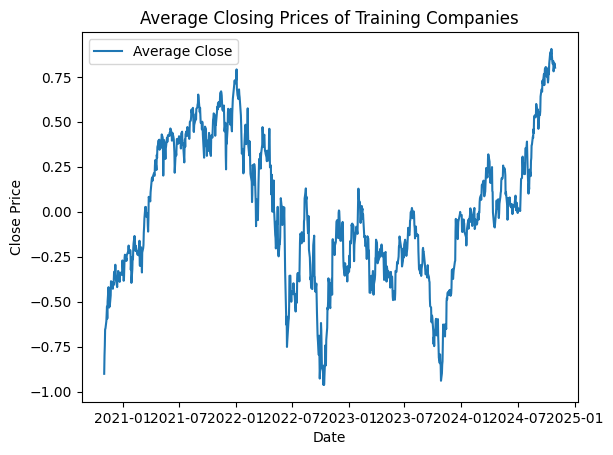

In [ ]:
# Create a plot of Average Closing Prices over time for training companies
companies_to_plot = train_companies
companies_to_plot = [company + '_Close' for company in companies_to_plot]

avg_close = train_data_df[companies_to_plot].mean(axis=1)
plt.plot(train_data_df.index, avg_close, label="Average Close")
plt.title('Average Closing Prices of Training Companies')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

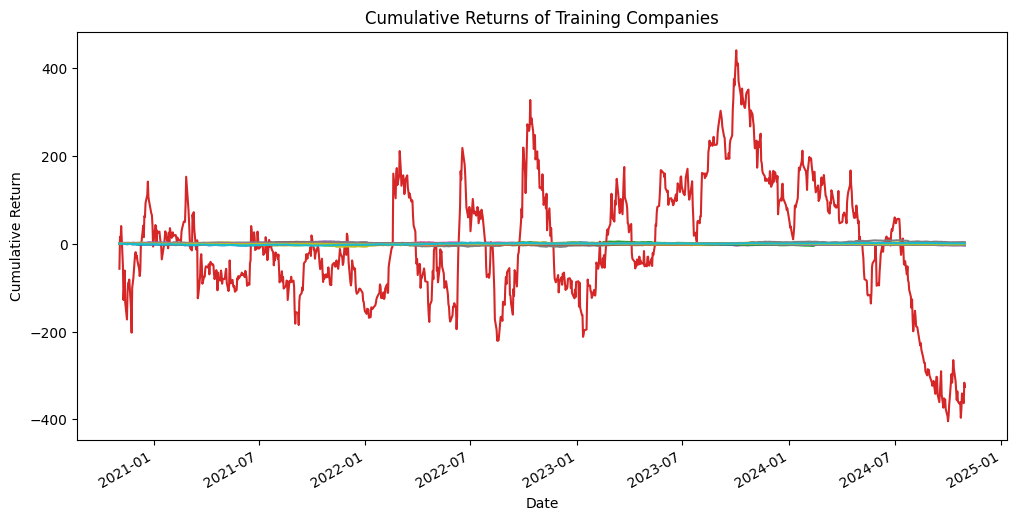

In [ ]:
# Plot Cumulative Return for all of the training companies
# Select only columns that contain 'Close' in their name, excluding 'Adj Close', 'SMA', 'RSI', etc.
close_columns = [col for col in train_data_df.columns if 'Close' in col and 'Adj Close' not in col and 'SMA' not in col and 'RSI' not in col]

# Calculate cumulative returns for these closing prices only
cumulative_returns = (train_data_df[close_columns].pct_change() + 1).cumprod()

# Plot the cumulative returns
cumulative_returns.plot(figsize=(12, 6), legend=False)
plt.title('Cumulative Returns of Training Companies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

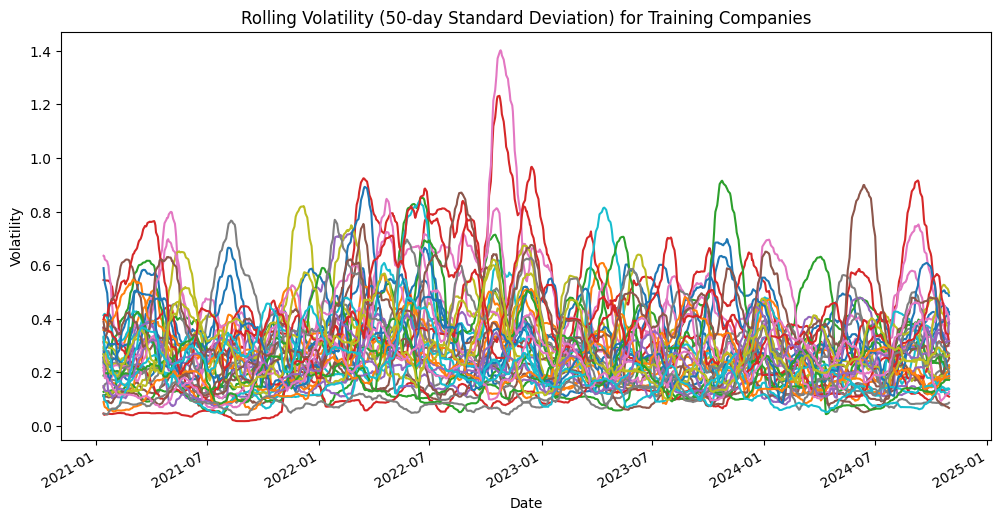

In [ ]:
# Plot to show the volatility across all training companies
rolling_volatility = train_data_df[[col for col in train_data_df.columns if 'Close' in col and 'Adj Close' not in col and 'SMA' not in col and 'RSI' not in col]].rolling(window=50).std()
rolling_volatility.plot(figsize=(12, 6), legend=False)
plt.title('Rolling Volatility (50-day Standard Deviation) for Training Companies')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

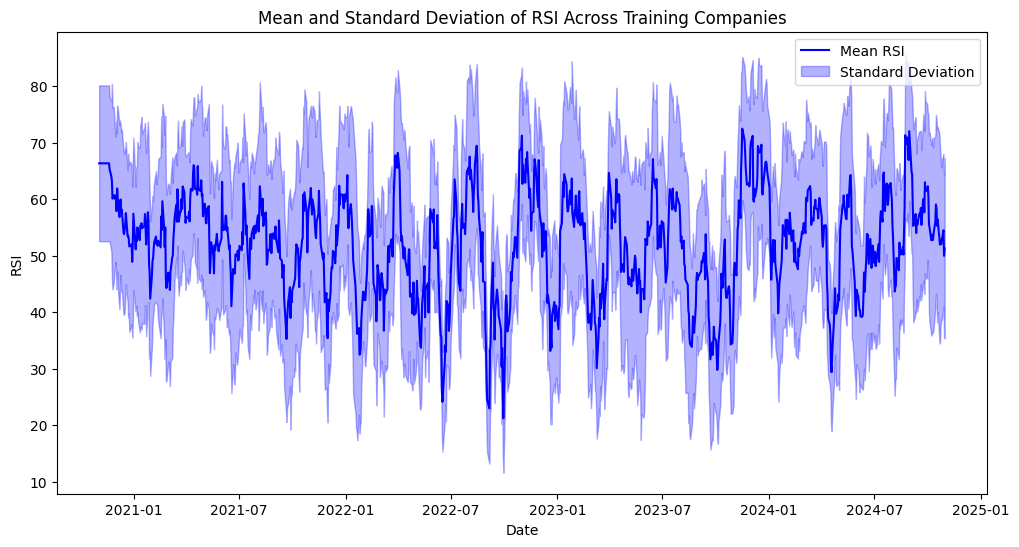

In [ ]:
# Plot to show the mean and standard deviation over all training companies
rsi_columns = [col for col in train_data_df.columns if 'RSI' in col]
rsi_data = train_data_df[rsi_columns]

mean_rsi = rsi_data.mean(axis=1)
std_rsi = rsi_data.std(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_data_df.index, mean_rsi, label='Mean RSI', color='b')
plt.fill_between(train_data_df.index, mean_rsi - std_rsi, mean_rsi + std_rsi, color='blue', alpha=0.3, label='Standard Deviation')
plt.title('Mean and Standard Deviation of RSI Across Training Companies')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

In [ ]:
# Filter and average relevant columns for each feature
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Close_SMA_50', 'Close_SMA_200', 'Close_RSI']

averaged_data = {}

for feature in features:
    # Match columns that contain the exact feature name
    feature_columns = [col for col in train_data_df.columns if feature in col and not any(sub in col for sub in ['Adj', 'SMA', 'RSI'])] if feature == 'Close' else \
                      [col for col in train_data_df.columns if feature in col]
    averaged_data[feature] = train_data_df[feature_columns].mean(axis=1)

# Create the new averaged dataframe
averaged_df = pd.DataFrame(averaged_data, index=train_data_df.index)

# Display the updated result to verify the values
print(averaged_df.head())

                           Adj Close     Close      High       Low      Open  \
Date_                                                                          
2020-11-02 00:00:00+00:00  -1.074715 -0.900885 -0.908711 -0.933363 -0.927956   
2020-11-03 00:00:00+00:00  -0.979156 -0.800349 -0.800693 -0.814248 -0.835119   
2020-11-04 00:00:00+00:00  -0.920279 -0.743033 -0.694738 -0.771445 -0.756454   
2020-11-05 00:00:00+00:00  -0.830648 -0.652492 -0.639218 -0.667063 -0.674851   
2020-11-06 00:00:00+00:00  -0.827902 -0.650089 -0.631527 -0.661103 -0.645767   

                             Volume  Close_SMA_50  Close_SMA_200  Close_RSI  
Date_                                                                        
2020-11-02 00:00:00+00:00  0.221758     -0.424375       0.031361  66.348042  
2020-11-03 00:00:00+00:00  0.274144     -0.424375       0.031361  66.348042  
2020-11-04 00:00:00+00:00  0.593391     -0.424375       0.031361  66.348042  
2020-11-05 00:00:00+00:00  0.216750     -0.424375

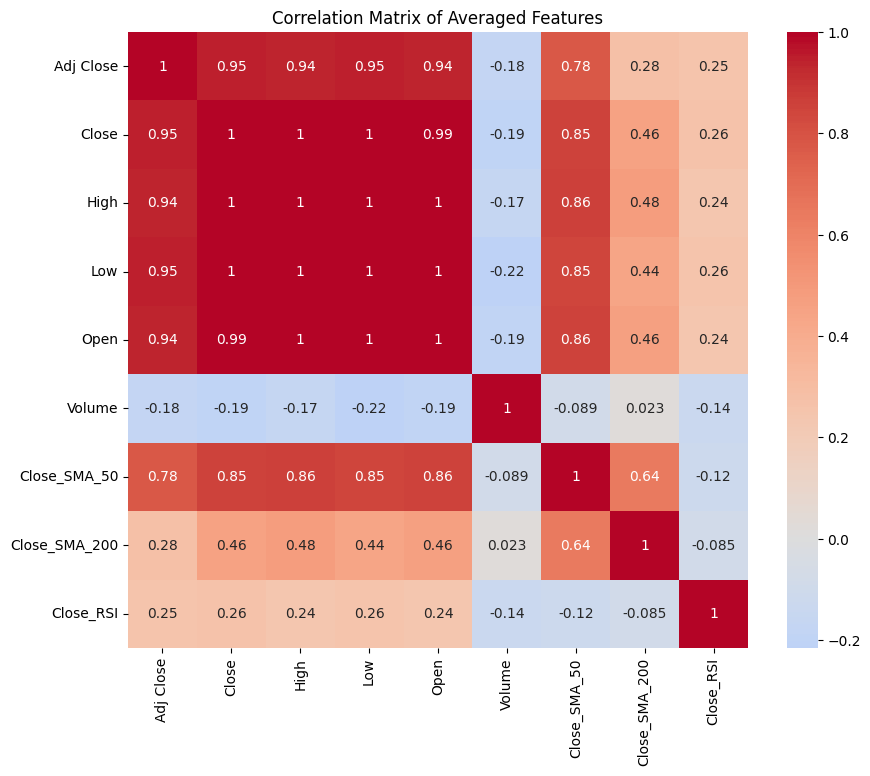

In [ ]:
# Calculate correlation matrix for the averaged dataframe
correlation_matrix = averaged_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Averaged Features')
plt.show()

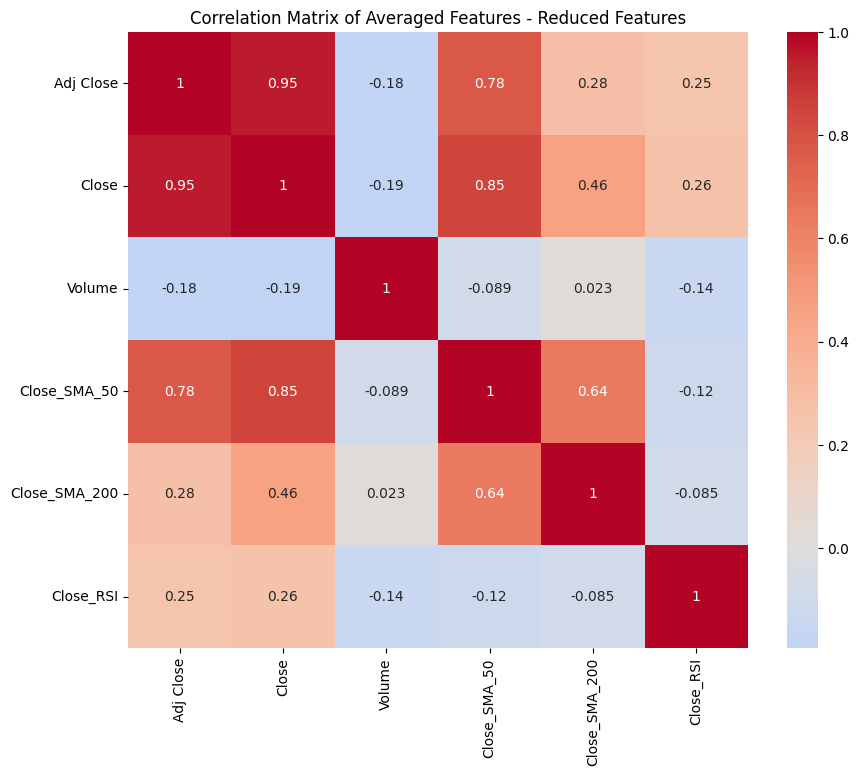

In [ ]:
# Define the columns to keep for predictions
columns_to_keep = ['Adj Close', 'Close', 'Volume', 'Close_SMA_50', 'Close_SMA_200', 'Close_RSI']

averaged_df = averaged_df[columns_to_keep]

# Calculate correlation matrix for the averaged dataframe with reduced features
correlation_matrix_drop_col = averaged_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_drop_col, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Averaged Features - Reduced Features')
plt.show()

# **STEP 3: MODEL BUILDING**
The objective is to evaluate the prediction accuracy of various supervised learning models on the closing prices of selected companies from the S&P 500 index. To achieve this, we will assess the following five models from Python’s sklearn package, performing a grid search to identify the optimal hyperparameters for each model. Our evaluation metrics will focus on minimizing Mean Squared Error (MSE) and maximizing R-squared (R²) values. Here are the models and their key parameters:
<br><br>
**Random Forest:** Number of Estimators, Max Depth, Min Samples Split, Min Samples Leaf, Bootstrap

**K-Nearest Neighbors:** Number of Neighbors, Weights, Distance Metric

**Decision Tree:** Max Depth, Min Samples Split, Min Samples Leaf

**Support Vector Regression (SVR):** Kernel, C (Regularization), Gamma (Kernel Coefficient)

**Linear Regression:** Fit Intercept (True/False)
<br><br>
To respect the time-dependent nature of our data, we use TimeSeriesSplit to divide the dataset into five sequential “folds.” This approach ensures that each model is trained on past data and validated on future data, simulating real-world forecasting conditions and avoiding data leakage.

During grid search, we apply all models with their corresponding hyperparameter combinations, calculating accuracy metrics for each. This yields a list of models with the parameter sets that achieved the best performance, as measured by MSE and R².

Finally, we use these tuned models to predict the stock prices of the remaining 10 randomly selected testing companies, allowing us to evaluate the models’ effectiveness on new data. The output consists of data frames showing the MSE and R² values for each “best model” applied to each of the 10 test companies’ data, providing a clear view of model performance across different companies.


In [ ]:
# Define the learning models to use
models = {
    'Random Forest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'SVR': SVR(),
    'Linear Regression': LinearRegression()
}

# Define hyperparameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    },
    'KNN': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
    },
    'Decision Tree': {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVR': {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'Linear Regression': {
        # No hyperparameters to tune for LinearRegression
        'fit_intercept': [True, False]
    }
}

# Use .flatten() to convert the Close_RSI 2D array into a 1D array
averaged_df.loc[:, 'Close_RSI'] = scaler.fit_transform(averaged_df[['Close_RSI']]).flatten()
X = averaged_df[['Adj Close', 'Volume', 'Close_SMA_50', 'Close_SMA_200', 'Close_RSI']]
y = averaged_df['Close']

In [ ]:
# Initialize TimeSeriesSplit
n_splits = 5  # Number of splits for time series cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize results dictionary to store performance
tscv_results = {}

# Train and evaluate models with hyperparameter tuning using TimeSeriesSplit
for name, model in models.items():
    print(f"Training {name}...")
    param_grid = param_grids[name]

    # Initialize GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=tscv, scoring='neg_mean_squared_error',
                               n_jobs=-1, verbose=2)

    grid_search.fit(X, y)

    # Best model and hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Store results
    print(f"Best parameters for {name}: {best_params}")
    best_mse = grid_search.best_score_
    best_r2 = grid_search.best_estimator_.score(X, y)

    tscv_results[name] = {'Best Params': best_params, 'Best MSE': -best_mse, 'Best R²': best_r2}

# Convert the results to a DataFrame for comparison
tscv_results_df = pd.DataFrame(tscv_results).T
print(tscv_results_df)

Training Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Training KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for KNN: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Training Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Training SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVR: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Training Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for Linear Regression: {'fit_intercept': True}
                                                         Best Params  \
Random Forest      {'bootstrap': True, 'max_depth': 10, '

In [ ]:
# Prepare test data for evaluating models
# Identify columns that end with '_Close_RSI' and scale them individually
rsi_columns = [col for col in test_data_df.columns if col.endswith('_Close_RSI')]

# Scale each RSI column independently
for rsi_column in rsi_columns:
    test_data_df[rsi_column] = scaler.fit_transform(test_data_df[[rsi_column]]).flatten()

# Check the result to ensure all RSI columns are scaled properly
print(test_data_df[rsi_columns].head())

                           RL_Close_RSI  HWM_Close_RSI  FDX_Close_RSI  \
Date_                                                                   
2020-11-02 00:00:00+00:00      0.838031       1.282484       0.521354   
2020-11-03 00:00:00+00:00      0.838031       1.282484       0.521354   
2020-11-04 00:00:00+00:00      0.838031       1.282484       0.521354   
2020-11-05 00:00:00+00:00      0.838031       1.282484       0.521354   
2020-11-06 00:00:00+00:00      0.838031       1.282484       0.521354   

                           ETN_Close_RSI  CAT_Close_RSI  CPAY_Close_RSI  \
Date_                                                                     
2020-11-02 00:00:00+00:00       0.835713        0.37895        0.721932   
2020-11-03 00:00:00+00:00       0.835713        0.37895        0.721932   
2020-11-04 00:00:00+00:00       0.835713        0.37895        0.721932   
2020-11-05 00:00:00+00:00       0.835713        0.37895        0.721932   
2020-11-06 00:00:00+00:00       0.8357

In [ ]:
# Extract the best models from tscv_results
best_models = {}

# Initialize best models with best parameters found
for model_name in tscv_results_df.index:
    # Retrieve the model and set best parameters
    best_models[model_name] = models[model_name].set_params(**tscv_results_df.loc[model_name, 'Best Params'])

for model_name, model in best_models.items():
    model.fit(X, y)

In [ ]:
# Initialize a dictionary to store performance metrics for each company
test_results = {}

# List of company names based on column prefixes in the test set
companies = [col.split('_')[0] for col in test_data_df.columns if 'Close' in col]

# Iterate over each company in the test set
for company in companies:
    company_results = {}

    # Dynamically build feature column names for the current company
    feature_columns = [f'{company}_Adj Close', f'{company}_Volume', f'{company}_Close_SMA_50',
                       f'{company}_Close_SMA_200', f'{company}_Close_RSI']

    # Extract relevant columns for the company
    company_data = test_data_df[feature_columns + [f'{company}_Close']]

    # Features (X) and target (y) for the current company
    X_test = company_data[feature_columns]
    y_test = company_data[f'{company}_Close']

    # Remove the company prefix from the feature columns for consistency with model training
    test_feature_columns = [col.split('_', 1)[1] for col in X_test.columns]  # Remove prefix

    # Select the columns from X_test that match the feature columns without the prefix
    X_test.columns = test_feature_columns

    # Iterate over each refitted best model
    for name, model in best_models.items():
        # Make predictions on the test set for the company
        y_pred = model.predict(X_test)

        # Evaluate performance
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Store the results for the company and model
        company_results[name] = {'RMSE': rmse, 'R²': r2}

    # Store the results for the company
    test_results[company] = company_results

# Convert results to a DataFrame for easy viewing and comparison
test_results_df = pd.DataFrame({model: {company: results[model] for company, results in test_results.items()} for model in best_models.keys()})

# Display the results
print(test_results_df)

                                          Random Forest  \
RL    {'RMSE': 0.49189137852745296, 'R²': 0.75804287...   
HWM   {'RMSE': 0.5212213786770398, 'R²': 0.728328274...   
FDX   {'RMSE': 0.47065373570075275, 'R²': 0.77848506...   
ETN   {'RMSE': 0.44549868375237983, 'R²': 0.80153092...   
CAT   {'RMSE': 0.44929990684726107, 'R²': 0.79812959...   
CPAY  {'RMSE': 0.44011465371164793, 'R²': 0.80629909...   
STE   {'RMSE': 0.43752449227153545, 'R²': 0.80857231...   
FAST  {'RMSE': 0.4534489067945391, 'R²': 0.794384088...   
BBY   {'RMSE': 0.37392772188016477, 'R²': 0.86017805...   
BKR   {'RMSE': 0.4079557191875777, 'R²': 0.833572131...   

                                                    KNN  \
RL    {'RMSE': 0.601646090271637, 'R²': 0.6380219820...   
HWM   {'RMSE': 0.6177247211902819, 'R²': 0.618416168...   
FDX   {'RMSE': 0.6007707856034805, 'R²': 0.639074463...   
ETN   {'RMSE': 0.5681684870585079, 'R²': 0.677184570...   
CAT   {'RMSE': 0.5596559087869147, 'R²': 0.686785263...

In [ ]:
# Extract RMSE and R² for each stock and model into separate columns
rmse_df = pd.DataFrame({col: test_results_df[col].apply(lambda x: x['RMSE']) for col in test_results_df.columns})
r2_df = pd.DataFrame({col: test_results_df[col].apply(lambda x: x['R²']) for col in test_results_df.columns})

# Display the RMSE and R² DataFrames
print(rmse_df)
print(r2_df)

      Random Forest       KNN  Decision Tree       SVR  Linear Regression
RL         0.491891  0.601646       0.489872  0.142119           0.152149
HWM        0.521221  0.617725       0.523042  0.074900           0.097228
FDX        0.470654  0.600771       0.457223  0.187578           0.191233
ETN        0.445499  0.568168       0.444782  0.088753           0.113826
CAT        0.449300  0.559656       0.448795  0.114024           0.130500
CPAY       0.440115  0.569899       0.430793  0.158719           0.165346
STE        0.437524  0.567058       0.437294  0.237454           0.241647
FAST       0.453449  0.568283       0.452059  0.179991           0.193276
BBY        0.373928  0.506262       0.371801  0.132747           0.145145
BKR        0.407956  0.539835       0.406029  0.220688           0.238902
      Random Forest       KNN  Decision Tree       SVR  Linear Regression
RL         0.758043  0.638022       0.760025  0.979802           0.976851
HWM        0.728328  0.618416       0.

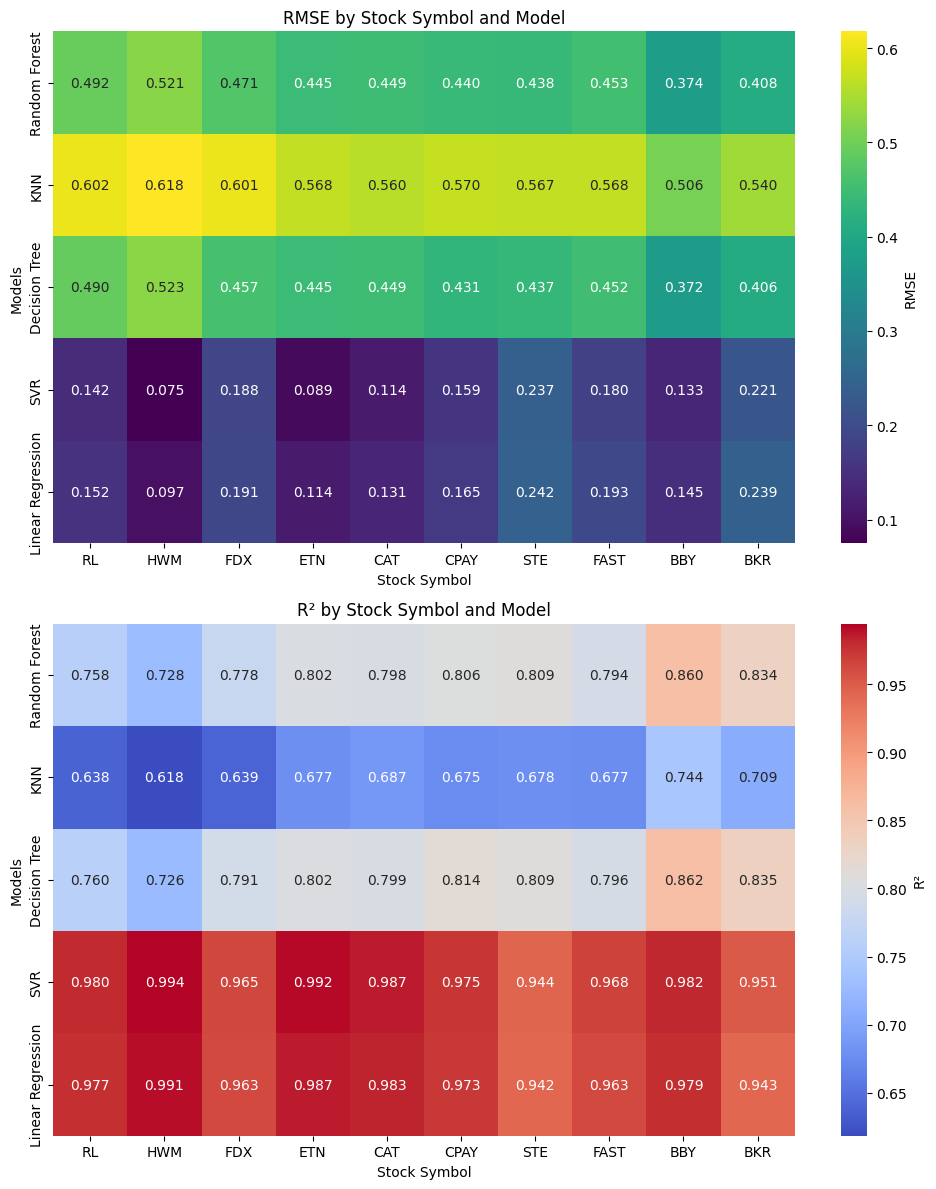

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# RMSE heatmap
sns.heatmap(rmse_df.T, annot=True, cmap='viridis', fmt='.3f', ax=axes[0], cbar_kws={'label': 'RMSE'})
axes[0].set_title('RMSE by Stock Symbol and Model')
axes[0].set_ylabel('Models')
axes[0].set_xlabel('Stock Symbol')

# R2 heatmap
sns.heatmap(r2_df.T, annot=True, cmap='coolwarm', fmt='.3f', ax=axes[1], cbar_kws={'label': 'R²'})
axes[1].set_title('R² by Stock Symbol and Model')
axes[1].set_ylabel('Models')
axes[1].set_xlabel('Stock Symbol')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# **STEP 4: RESULTS AND ANALYSIS**
Using a 5-year dataset of averaged, standardized data from 40 randomly selected companies in the S&P 500 index, we applied five supervised learning models—Random Forest, K-Nearest Neighbors (KNN), Decision Tree, Support Vector Regression (SVR), and Linear Regression—to determine the best models and combinations of hyperparameters for predicting stock closing prices. We specifically used Mean Squared Error (MSE) and R-squared (R²) as performance metrics.
<br><br>
### **Model Training Results**
Each model was trained using TimeSeriesSplit cross-validation, paired with a grid search to determine the optimal hyperparameters. The following best parameter configurations and scores were obtained:
<br><br>
**Random Forest:** Best MSE of 0.0227 and R² of 0.9996 with parameters bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, and n_estimators=50.

**K-Nearest Neighbors (KNN):** Best MSE of 0.0409 and R² of 1.0 with parameters n_neighbors=10, p=1, and weights='distance'.

**Decision Tree:** Best MSE of 0.0232 and R² of 0.9994 with parameters max_depth=10, min_samples_leaf=2, and min_samples_split=2.

**Support Vector Regression (SVR):** Best MSE of 0.0184 and R² of 0.9563 with parameters C=0.1, gamma='scale', and kernel='linear'.

**Linear Regression:** Best MSE of 0.0214 and R² of 0.9574 with fit_intercept=True.
<br><br>
From these training results, Random Forest, KNN, and Decision Tree models achieved the highest R² values, with KNN reaching 1.0, though it had a higher MSE than both Random Forest and SVR. SVR and Linear Regression both achieved high R² scores but had slightly lower accuracy compared to the top three models.
<br><br>
### **Model Testing Results**
After tuning the models, we applied the best configurations to the remaining 10 randomly selected companies, evaluating their performance using both MSE and R² scores. The results are summarized below:
<br><br>
**Random Forest:** Average MSE of 0.490, average R² of 0.798. Performed consistently across most companies with relatively high R² values, indicating strong predictive accuracy.

**K-Nearest Neighbors (KNN):** Average MSE of 0.589, average R² of 0.669. KNN showed lower predictive accuracy, as its distance-based approach may struggle with the complexity of stock price relationships, which can be more non-linear.

**Decision Tree:** Average MSE of 0.492, average R² of 0.800. Similar to Random Forest, Decision Tree performed well but occasionally showed higher variability in its predictions.

**Support Vector Regression (SVR):** Average MSE of 0.140, average R² of 0.973. SVR excelled in minimizing prediction errors, likely due to its linear kernel’s ability to effectively capture trends.

**Linear Regression:** Average MSE of 0.160, average R² of 0.970. Linear Regression also performed well, showing strong predictive accuracy across the companies.
<br><br>
These results were further illustrated using two heatmaps (one for MSE and the other for R²), which visually captured the performance of each model across different companies, helping highlight the relative strengths of each model.
<br><br>
### **Analysis**
The results show that SVR and Linear Regression outperformed the other models in terms of both lower MSE and higher R² values. This suggests that simpler, linear models can be highly effective for predicting stock prices. A likely reason for this is the time-series nature of stock data, where linear trends often dominate in short-term forecasting. While Random Forest and Decision Tree models also performed well, they occasionally showed higher errors, possibly due to overfitting or sensitivity to the volatility of stock prices.

In conclusion, **SVR and Linear Regression** were the most effective models for stock price prediction in this analysis, with SVR offering the best balance of accuracy and error minimization. However, Random Forest and Decision Tree may still be valuable for capturing more complex, non-linear patterns in data, depending on the dataset’s characteristics.

# **STEP 5: CONCLUSION**
In this project, we applied five supervised learning models—Random Forest, K-Nearest Neighbors (KNN), Decision Tree, Support Vector Regression (SVR), and Linear Regression—to predict the closing prices of stocks from 40 randomly selected companies in the S&P 500 index. After careful model tuning and evaluation, we found that SVR and Linear Regression outperformed the other models in terms of both lower Mean Squared Error (MSE) and higher R-squared (R²) values. This suggests that simpler, linear models can be highly effective for predicting short-term stock price trends, likely due to the linear nature of many stock price movements over shorter periods.

While SVR and Linear Regression showed strong performance in this study, models such as Random Forest and Decision Trees also provided valuable insights, especially in capturing more complex, non-linear relationships within the data. These results indicate that a combination of model types or hybrid approaches could be explored in future work to improve predictive accuracy.
<br><br>
### **Future Areas of Research**
There are several potential directions for future research to expand and enhance the predictive power of stock price prediction models:
<br><br>
**Testing on Additional S&P 500 Companies:** The current dataset included only 40 companies from the S&P 500 index. Expanding the dataset to cover a broader selection of companies and grouping by industry could offer a more comprehensive understanding of model performance across different sectors. Testing a larger and more diverse set of companies would help assess the consistency of the models’ performance and identify any patterns related to specific industries or companies.

**Applying Models to Non-S&P 500 Stocks:** Expanding the models to include stocks outside the S&P 500 index, particularly those from smaller companies or emerging markets, would offer valuable insights into the models’ generalizability. These stocks often experience higher volatility or lack the extensive historical data found in larger companies, presenting unique challenges that could test the models’ robustness in different market conditions.

**Longer Time Horizons:** This project focused on a 5-year time span for both training and testing the models. Future research could explore longer time horizons, both in terms of the historical data used and the prediction window into the future. Predicting stock prices over a longer period would present additional challenges due to the greater influence of external factors such as economic shifts, geopolitical events, and market cycles, which may require more advanced forecasting techniques.

**Testing Other Models and Techniques:** While the models used in this study performed well, exploring additional machine learning algorithms, such as Gradient Boosting, XGBoost, or Long Short-Term Memory (LSTM) networks, could improve predictive power. These models are better equipped to handle more complex relationships and may be especially useful in time-series forecasting. Additionally, incorporating external factors like macroeconomic indicators, sentiment analysis, or even social media data could further enhance model performance.
<br><br>
### **Conclusion**
While this project demonstrated the potential of supervised learning models in predicting stock closing prices, further exploration into more diverse datasets, advanced models, and longer time horizons is essential to improve predictive accuracy. The future of stock price prediction lies in continually refining these models and exploring innovative ways to incorporate a wider range of factors that influence market behavior.




---



1. Wikipedia contributors. (n.d.). List of S&P 500 companies. Wikipedia. Retrieved November 8, 2024, from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
2. Saxo Bank. (n.d.). A guide to the 10 most popular trading indicators. Saxo. Retrieved November 8, 2024, from https://www.home.saxo/learn/guides/trading-strategies/a-guide-to-the-10-most-popular-trading-indicators
3. GeeksforGeeks. (2021, July 22). How to use yfinance API with Python. GeeksforGeeks. Retrieved November 12, 2024, from https://www.geeksforgeeks.org/how-to-use-yfinance-api-with-python/

